In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install arrow
!pip install geopandas
# !pip install osmnx==1.1.1
# !pip install pandana
!pip install haversine
!pip install --upgrade folium
!pip install --upgrade statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 66 kB 2.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 6.4 MB/s 
     |████████████████████████████████| 6.3 MB 33.5 MB/s 
     |████████████████████████████████| 16.7 MB 23.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 3.4 MB/s 
  Attempting uninstall: folium
    Found existing installation: folium 0.12.1.post1
    Uninstalling folium-0.12.1.post1:
      Successfully uninstalled folium-0.12.1.post1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.9 MB

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
import branca
import folium
import geopandas as gpd
import seaborn as sns
import cProfile
import sys
import pickle
import arrow
import datetime
from argparse import ArgumentParser

from shapely.geometry import Polygon, Point, MultiPoint, MultiPolygon
from shapely.affinity import affine_transform
from descartes.patch import PolygonPatch
from shapely.ops import cascaded_union
from matplotlib.path import Path

from scipy.stats import multivariate_normal
from scipy.spatial.distance import pdist, squareform
from scipy.stats import gaussian_kde

from sklearn import preprocessing
from sklearn.cluster import KMeans

import scipy.sparse as sp

In [5]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from abc import ABC, abstractmethod
import networkx as nx
from community import community_louvain
from haversine import haversine, haversine_vector

In [6]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import os
import itertools

# Kernel

In [7]:
class Multivariate_Exponential_Kernel(torch.nn.Module):
    """
    Exponential Decaying Kernel
    """
    def __init__(self, alphas, beta, device):
        """
        Arg:
        - alphas: influence coefficient matrix, numpy array                     [ n_class, n_class ]
        - beta: temporal decaying parameter for historical influence, numpy array        [ n_class ]
        - device: cpu or cuda
        """
        super(Multivariate_Exponential_Kernel, self).__init__()

        # configuration
        self._alphas     = torch.nn.Parameter(torch.tensor(alphas))
        self._beta       = torch.nn.Parameter(torch.tensor(beta))
        self.n_class     = alphas.shape[0]

    def init_paras(self):
        """
        initialize model parameters
        """

        self._alphas.data = torch.empty(torch.empty(self.n_class, self.n_class).uniform_(0,to=self.init_std)).to(self._alphas.device)
        self._beta.data = torch.empty(torch.empty(self.n_class).uniform_(0,to=self.init_std)).to(self._beta.device)
    
    def forward(self, x, y):
        """
        customized forward function returning kernel evaluation at index x and y 
        - x: the current input (t, type) [ batch_size, data_dim = 2 ]
        - y: the history input (t, type) [ batch_size, data_dim = 2 ]
        """

        batch_size   = x.shape[0]
        alphas_hist  = self._alphas[x[:, 1].long(), y[:, 1].long()]
        beta_hist    = self._beta[y[:, 1].long()]

        mask         = x[:, 0] > 0
        tds          = (x[:, 0] - y[:, 0]) * mask

        return alphas_hist * beta_hist * torch.exp(- beta_hist * tds) * mask    # [ batch_size ]

# PP

In [34]:
class BasePointProcess(torch.nn.Module):
    """
    PyTorch Module for Multivariate Point Process with diffusion kernel
    """

    def __init__(self, T, mu, data_dim, device):
        """
        data dim = 8

        Args:
        """
        super(BasePointProcess, self).__init__()
        self.data_dim      = data_dim
        self.T             = T # time horizon. e.g. (0, 1)
        self.device        = device
        self.n_class       = len(mu)
        
        # parameters
        self._mu = torch.nn.Parameter(torch.tensor(mu), requires_grad=False)
        # # pre-compute
        # self.data_transformation()

    def cond_lambda(self, xi, hti):
        """
        return conditional intensity given x
        Args:
        - xi:   current i-th point       [ batch_size, data_dim ]
        - hti:  history points before ti [ batch_size, seq_len, data_dim ]
        Return:
        - lami: i-th lambda              [ batch_size ]
        """
        batch_size, seq_len, _ = hti.shape
        mask_all = (hti[:, :, 0] > 0) * (xi[:, 0] > 0)[:, None]
        # if length of the history is zero
        if seq_len == 0:
            return self._mu[xi[:, 1].long()]                                    # [ batch_size ]

        xi2  = xi.unsqueeze(-2).repeat(1, seq_len, 1)                           # [ batch_size, seq_len, data_dim ]
        K    = self.kernel(xi2.reshape(-1, self.data_dim),
                           hti.reshape(-1, self.data_dim)).reshape(batch_size, seq_len)                                           
                                                                                # [ batch_size, seq_len ]
        lami = (K * mask_all).sum(-1) + self._mu[xi[:, 1].long()]                                 
                                                                                # [ batch_size ]
        return lami             # [ batch_size ]

    def log_likelihood(self, X):
        """
        return log-likelihood given sequence X
        Args:
        - X:      input points sequence [ batch_size, seq_len, data_dim ]
        Return:
        - lams:   sequence of lambda    [ batch_size, seq_len ]
        - loglik: log-likelihood        scalar
        """
        
        raise NotImplementedError()

    def forward(self, X):
        """
        custom forward function returning conditional intensities and corresponding log-likelihood
        """
        # return conditional intensities and corresponding log-likelihood
        return self.log_likelihood(X)

    # def mu(self):
    #     """
    #     return base intensity
    #     """
    #     raise NotImplementedError()



class MultivariateExponentialHawkes(BasePointProcess):
    """
    PyTorch Module for Multivariate Temporal Point Process
    """
    def __init__(self, T, mu, alphas, beta, data_dim, device):
        """
        data dim = 5(time, x, y, type)

        Args:
        """
        super(MultivariateExponentialHawkes, self).__init__(T, mu, data_dim, device)
        
        # kernel
        self.kernel = Multivariate_Exponential_Kernel(alphas, beta, device)
        # # pre-compute
        # self.data_transformation()

    def log_likelihood(self, X):
        """
        return log-likelihood given sequence X
        Args:
        - X:      input points sequence [ batch_size, seq_len, data_dim ]
        Return:
        - lams:   sequence of lambda    [ batch_size, seq_len ]
        - loglik: log-likelihood        scalar
        """

        batch_size, seq_len, _ = X.shape
        ts       = X[:, :, 0].clone()
        ms       = X[:, :, 1].clone().long()
        mask     = ts > 0

        lams     = [
            self.cond_lambda(X[:, i, :].clone(), X[:, :i, :].clone())
            for i in range(seq_len) ]
        lams     = torch.stack(lams, dim=0).T                                   # [ batch_size, seq_len ]
        ## log-likelihood
        mask     = ts > 0                                                       # [ batch_size, seq_len ]
        sumlog   = (torch.log(lams + 1e-8) * mask).sum()                        # [ seq_len ]

        baserate = torch.sum(self._mu * (self.T[1] - self.T[0]))

        temp_int = 1 - torch.exp(-self.kernel._beta[ms] * (self.T[1] - ts))            # [ batch_size, seq_len ]
        alpha_int = self.kernel._alphas[:, ms].sum(0)
        integ = alpha_int * temp_int * mask
        integ = integ.sum()

        loglik = sumlog - baserate - integ
        
        return loglik

# Training Function

In [24]:
def train(model,
          train_data,
          device,
          modelname,
          rootpath,
          num_epochs=20, 
          lr=1e-4,
          batch_size=5,
          print_iter=2,
          tol=1e-2,
          testing=False,
          test_data=None,
          save_model=False):
    """training procedure for one epoch"""

    clipper1  = NonNegativeClipper()
    ##clipper2  = ProximityClipper(coords, k=k)
    # NOTE: gradient for loss is expected to be None, 
    #       since it is not leaf node. (it's root node)

    path = rootpath + "/Results/saved_models/%s" % modelname
    
    if save_model:
        if os.path.exists(path): 
            print("Duplicated folder!")
            return None
        else:
            os.makedirs(path)

    model.to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=lr)

    best_lglk = -np.inf
    prev_lglk = -np.inf
    no_incre = 0
    converge = 0
    _lr = lr
    n_batches = int(train_data.shape[0] / batch_size) # number of batches

    train_llk = []
    test_llk = []

    for i in range(num_epochs):
        try:
            epoch_llk_loss = 0
            epoch_l1_loss  = 0
            optimizer.zero_grad()

            for b in range(n_batches):
                idx  = np.arange(batch_size * b, batch_size * (b + 1))
                data = train_data[idx]
                loglik = model(data.to(device))
                loss      = - loglik

                loss.backward()
                optimizer.step()
                model.apply(clipper1)
            
                epoch_llk_loss += loglik.item()
            
            event_num = (train_data[..., 0] > 0).sum()
            event_llk = epoch_llk_loss / event_num

            if (i+1) % print_iter == 0:

                train_llk.append(event_llk)
                print("[%s] Epoch: %d\tTrain Loglik: %.3e\t stag: %d converge: %d" % (arrow.now(), 
                    i, 
                    event_llk,
                    no_incre,
                    converge))
                
                if testing:
                    with torch.no_grad():
                        test_loglik = model(test_data.to(device))
                        test_event_num = (test_data[..., 0] > 0).sum()
                        test_event_llk = test_loglik / test_event_num

                        test_llk.append(test_event_llk)
                
                        print("[%s] Epoch: %d\tTest Loglik: %.3e" % (arrow.now(), 
                            i, 
                            test_event_llk))
                
            if event_llk > best_lglk:
                best_lglk = event_llk
                no_incre = 0
            else:
                no_incre += 1
            if no_incre == 10:
                print("Learning rate decrease!")
                _lr = _lr / 10
                optimizer = optim.Adadelta(model.parameters(), lr=_lr)
                no_incre = 0
                # best_lglk = -np.inf
            if np.abs(event_llk - prev_lglk) > tol:
                converge = 0
            else:
                converge += 1

            prev_lglk = event_llk
            
            if converge == 50:
                return train_llk, test_llk

            if save_model:
                model.cpu()
                torch.save(model.state_dict(), "%s/%s-%d.pth" % (path, modelname, i))
                model.to(device)

        except KeyboardInterrupt:
            break
    
    return train_llk, test_llk


class NonNegativeClipper(object):
    """
    References:
    https://discuss.pytorch.org/t/restrict-range-of-variable-during-gradient-descent/1933
    https://discuss.pytorch.org/t/set-constraints-on-parameters-or-layers/23620/3
    """

    def __init__(self):
        pass

    def __call__(self, module):
        """enforce non-negative constraints"""
        if hasattr(module, '_mu'):
            _mu = module._mu.data
            module._mu.data = torch.clamp(_mu, min=0.)
        # Multivariate Hawkes
        if hasattr(module, '_alphas'):
            _alphas = module._alphas.data
            module._alphas.data = torch.clamp(_alphas, min=1e-5)
        if hasattr(module, '_beta'):
            _beta  = module._beta.data
            module._beta.data  = torch.clamp(_beta, min=1e-5)

# Data Loading

In [25]:
rootpath = "/content/drive/MyDrive/CSE8803_DSE"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
train_raw_data = np.load(rootpath + "/data/train.npy", allow_pickle=True)
test_raw_data = np.load(rootpath + "/data/test.npy", allow_pickle=True)

In [27]:
lens_test = [test_raw_data[i][0].shape[0] for i in range(test_raw_data.shape[0])]
max_len_test = max(lens_test)

test_data = np.zeros((test_raw_data.shape[0], max_len_test, 2))
for i in range(test_raw_data.shape[0]):
    data = test_raw_data[i][0]
    data[:, 0] = data[:, 0] - 200
    test_data[i, :lens_test[i], :] = data

In [28]:
train_data_all = []

for i in range(train_raw_data.shape[0]):

    train_data_list = []
    for k in range(4):
        dat = train_raw_data[i][k]
        mask = dat[:, 0] > 0
        dat[:, 0] = (dat[:, 0] - k * 50) * mask
        train_data_list.append(dat)
    train_data_list = np.stack(train_data_list, axis=0)

    train_data_all.append(train_data_list)

lens_train = [data.shape[1] for data in train_data_all]
max_len_train = max(lens_train)

train_data = np.zeros((train_raw_data.shape[0], train_raw_data.shape[1], max_len_train, 2))
for i in range(train_raw_data.shape[0]):
    train_data[i, :, :lens_train[i], :] = train_data_all[i]

# Model Training

In [59]:
############### Training without regularization ################

seed = 500
torch.random.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# training configurations
batch_size = 4
num_epochs = 1000
lr         = 1e0

# model configurations
T          = np.array([0., 50.])
data_dim   = 2
device     = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device     = "cpu"
n_class    = 11
n_state    = train_raw_data.shape[0]

# mask = train_data[:, :, 0] > 0
# v, c = np.unique(train_data[mask][:, 0], return_counts=True)
# mu = c / train_data.shape[0] / 50 / 10
# print(mu)
# mu = np.zeros(n_class) * 1e-3

test_event_num = (test_data[:, :, 0] > 0).sum(1)
wo_fed_test_llk = np.zeros((n_state, n_state))

dir_path = rootpath + "/Results/saved_models"
if os.path.exists(dir_path): 
    print("Duplicated folder!")
else:
    os.makedirs(dir_path)

for i in range(n_state):

    alphas = np.random.uniform(low=0.0, high=1.0, size=(n_class, n_class))
    beta   = np.random.uniform(low=0.0, high=1.0, size=(n_class))

    train_set  = torch.FloatTensor(train_data[i])

    # mask = train_set[..., 0] > 0
    # v, c = np.unique(train_set[mask][:, 0], return_counts=True)
    # mu = c / train_set.shape[0] / 50 
    # print(mu)
    mu = np.ones(n_class) * 1e-2

    init_model = MultivariateExponentialHawkes(T=T, mu=mu, alphas=alphas, beta=beta,
                                            data_dim=data_dim, device=device)
    # init_model.load_state_dict(torch.load("/content/drive/MyDrive/Neural_Kernel/Deep_Fourier_Kernel/Results/saved_models/%s_stone12/%s-99.pth" % (modelname, modelname)))
    # # # define point process generator and generator synthetic data
    # # generator  = TemporalPointProcessGenerator(trg_model, upper_bound=1e+2)
    # # data, size = generator.generate(T=T, batch_size=2000, min_n_points=5, verbose=False)
    # # np.save("%s/data-1d-n2000_exponential_targetmodel-%d.npy" % (rootpath, seed), data)
    # # print(data.shape)

    # training data preparation
    # train_dataset = TensorDataset(train_data)
    # train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # training
    modelname  = "No_Fed-constant-mu%.3f-%d_train-state-%d" % (0.01, seed, i)
    train_llk, test_llk = train(init_model, train_set, device=device,
                modelname=modelname, rootpath=rootpath,
                num_epochs=num_epochs, lr=lr, batch_size=batch_size,
                print_iter=50, tol=1e-3, testing=False, test_data=None, save_model=False)
    
    modelpath = dir_path + "/%s.pth" % modelname
    init_model.cpu()
    torch.save(init_model.state_dict(), "%s" % modelpath)
    
    # with torch.no_grad():
    #     for j in range(n_state):
    #         test_set   = torch.FloatTensor(test_data[[j]])
    #         test_loglik = init_model(test_set.to(device))
    #         test_event_llk = test_loglik / test_event_num[j]
    #         print("Train/Test State (%d, %d),  testing llk: %.5f" % (i, j, test_event_llk))
    #         wo_fed_test_llk[i, j] = test_event_llk

Duplicated folder!
[2022-11-30T03:38:41.329257+00:00] Epoch: 49	Train Loglik: -2.916e+00	 stag: 0 converge: 0
[2022-11-30T03:38:46.230578+00:00] Epoch: 99	Train Loglik: -2.245e+00	 stag: 0 converge: 0
[2022-11-30T03:38:51.141478+00:00] Epoch: 149	Train Loglik: -1.909e+00	 stag: 6 converge: 0
[2022-11-30T03:38:55.982478+00:00] Epoch: 199	Train Loglik: -1.810e+00	 stag: 0 converge: 0
[2022-11-30T03:39:01.315187+00:00] Epoch: 249	Train Loglik: -1.754e+00	 stag: 1 converge: 0
[2022-11-30T03:39:06.815107+00:00] Epoch: 299	Train Loglik: -1.708e+00	 stag: 1 converge: 0
[2022-11-30T03:39:11.658015+00:00] Epoch: 349	Train Loglik: -1.666e+00	 stag: 0 converge: 9
[2022-11-30T03:39:16.515635+00:00] Epoch: 399	Train Loglik: -1.624e+00	 stag: 0 converge: 0
[2022-11-30T03:39:23.087899+00:00] Epoch: 449	Train Loglik: -1.584e+00	 stag: 0 converge: 0
[2022-11-30T03:39:28.032346+00:00] Epoch: 499	Train Loglik: -1.537e+00	 stag: 0 converge: 24
[2022-11-30T03:39:35.253912+00:00] Epoch: 49	Train Loglik: -2.

In [20]:
np.save(dir_path + "/%s_testing_llk.npy" % modelname, wo_fed_test_llk)

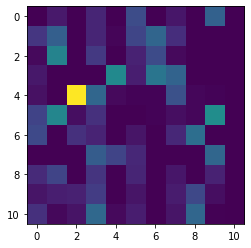

In [21]:
plt.imshow(init_model.kernel._alphas.detach().numpy())

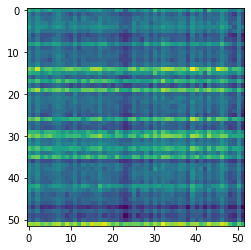

In [22]:
plt.imshow(wo_fed_test_llk)

In [32]:
wo_fed_test_llk = np.load(dir_path + "/No_Fed_testing.npy")

In [33]:
wo_fed_test_llk.mean()

-2.2543094777432553

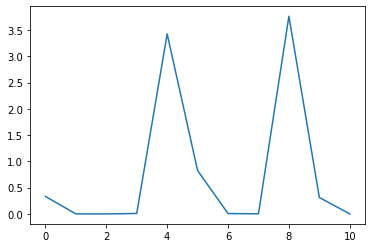

In [ ]:
plt.plot(init_model.kernel._beta.detach().numpy())

In [ ]:
init_model.kernel._beta.detach().numpy()

array([3.33075412e-01, 1.00000000e-05, 1.00000000e-05, 8.17423661e-03,
       3.42687872e+00, 8.24890602e-01, 6.96250672e-03, 1.75350690e-03,
       3.76325095e+00, 3.12796746e-01, 1.00000000e-05])

# Results

National Data Baseline

In [71]:
init_model = MultivariateExponentialHawkes(T=T, mu=mu, alphas=alphas, beta=beta,
                                            data_dim=data_dim, device=device)

dir_path = rootpath + "/Results/saved_models"
modelname  = "No_Fed-constant-mu%.3f-%d_train-state-%d" % (0.01, seed, 51)
modelpath = dir_path + "/%s.pth" % modelname

init_model.load_state_dict(torch.load("%s" % modelpath))
# init_model._mu = torch.nn.Parameter(torch.ones(11) * 1e-2, requires_grad=False)

<All keys matched successfully>

In [72]:
nation_test_llk = []

with torch.no_grad():
    for j in range(51):
        test_set   = torch.FloatTensor(test_data[[j]])
        test_loglik = init_model(test_set.to("cpu"))
        test_event_llk = test_loglik / test_event_num[j]
        nation_test_llk.append(test_event_llk.item())

In [73]:
np.mean(nation_test_llk)

-1.4892034649421042

Model ensemble

In [74]:
alphas = []
betas = []

dir_path = rootpath + "/Results/saved_models"

for i in range(51):
    modelname  = "No_Fed-constant-mu%.3f-%d_train-state-%d" % (0.01, seed, i)
    modelpath = dir_path + "/%s.pth" % modelname
    paras = torch.load("%s" % modelpath)

    alphas.append(paras["kernel._alphas"].numpy())
    betas.append(paras["kernel._beta"].numpy())

In [75]:
alphas = np.stack(alphas, axis = 0).mean(0)
beta = np.stack(betas, axis = 0).mean(0)
mu = np.ones(11) * 0.01

init_model = MultivariateExponentialHawkes(T=T, mu=mu, alphas=alphas, beta=beta,
                                            data_dim=data_dim, device=device)

In [76]:
ens_test_llk = []

with torch.no_grad():
    for j in range(51):
        test_set   = torch.FloatTensor(test_data[[j]])
        test_loglik = init_model(test_set.to("cpu"))
        test_event_llk = test_loglik / test_event_num[j]
        ens_test_llk.append(test_event_llk.item())

In [77]:
np.mean(ens_test_llk)

-3.06227251545091